In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# PATH = '/content/drive/MyDrive/MITB/4 2023 Aug/ISSS609 Text Analytics and Applications/AnalyzingDisneylandReviews'
PATH = '..'

# Sentiment Analysis
https://www.kaggle.com/code/ganiesenov/sentiment-analysis-using-nltk-gensim-models

ABSA
* https://github.com/yangheng95/PyABSA/blob/v2/examples-v2/aspect_polarity_classification/Aspect_Sentiment_Classification.ipynb
* https://www.kaggle.com/code/phiitm/aspect-based-sentiment-analysis
* https://www.kaggle.com/code/nkitgupta/aspect-based-sentiment-analysis


TRY
https://blog.futuresmart.ai/aspect-based-sentiment-analysis-with-pyabsa-hugging-face

In [ ]:
# Required libraries in Colab
! pip install transformers==4.29.0 pyabsa==1.16.14 sentencepiece contractions num2words accelerate --quiet

In [5]:
import sys
import timeit

import numpy as np
import pandas as pd
import re
import math
from tqdm import tqdm, tqdm_pandas
from tqdm.autonotebook import tqdm
tqdm_pandas = tqdm.pandas()

import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
import plotly.express as px
from wordcloud import WordCloud
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import PlaintextCorpusReader, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer


from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import Normalizer, MinMaxScaler

import torch
# Check if GPU is available and use it if available, otherwise use CPU
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

SEED = 2023

/var/folders/0g/_vw0ydz94_x5cpswktv47t9h0000gn/T/ipykernel_77224/1647534875.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
[nltk_data] Downloading package stopwords to /Users/sx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sx/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sx/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sx/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sx/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [6]:
# Setting list of stopwords
stop_words = set(stopwords.words('english'))
custom_stopwords = ['disneyland', 'park', 'disney', 'hongkong', 'hong', 'kong', 'mtr', 'orlando', 'shanghai','california','tokyo',
                    'japan', 'paris', 'would', 'could', 'place', 'visit', 'bring', 'following', 'follow', 'hk', 'hkg', 'themepark', 'day']
stop_words.update(custom_stopwords)

## 1. Load data

### 1.1 Import data

In [67]:
# Import data
df = pd.read_pickle(PATH+'/data/processed_reviews_with_ctry.pkl')

print(f"{len(df)} rows.")
df.head(5)

86048 rows.


Review_ID  Sentence_ID  Review_Year  Review_Month            Branch  \
0          1            1         2023             9  Disneyland_Tokyo   
1          1            2         2023             9  Disneyland_Tokyo   
2          1            3         2023             9  Disneyland_Tokyo   
3          1            4         2023             9  Disneyland_Tokyo   
4          1            5         2023             9  Disneyland_Tokyo   

   Rating Review_Country                        Review_Title  \
0       5       Malaysia  Worth every penny and every minute   
1       5       Malaysia  Worth every penny and every minute   
2       5       Malaysia  Worth every penny and every minute   
3       5       Malaysia  Worth every penny and every minute   
4       5       Malaysia  Worth every penny and every minute   

                                                                                                                                        Review_Text  
0                                                                   I visited Disney Land Tokyo with my family on a weekend night in December 2022.  
1                                                  We bought the evening entry that allowed us to enter the park after 3 p.m. at a discounted rate.  
2  We thought it was a great deal because we could still enjoy most of the attractions, parades, and shows without spending too much time or money.  
3                                                                     We arrived at the park around 4 p.m. and headed straight to Tokyo Disneyland.  
4                                                                           We were amazed by the beautiful decorations and the festive atmosphere.

### 1.2 Check length of strings

In [68]:
df["Review_Text_Length"] = df["Review_Text"].apply(lambda x : len(x.split()))

fig = px.histogram(df, x="Review_Text_Length",
                   title="Number of documents by number of characters",
                   hover_data=["Review_ID","Sentence_ID"],
                   marginal = "box")
fig.show()

### 1.3 Delete sentences with > 512 chars

In [69]:
MAX_SEQ_LENGTH = 512

In [70]:
# Reviews with sentences > MAX_SEQ_LENGTH
ids = df["Review_ID"][df["Review_Text_Length"] > MAX_SEQ_LENGTH]
ids = set(ids)
ids


{11008}

In [71]:
before = len(df)
print(f"Before deletion: {before} rows.")

df = df[~df["Review_ID"].isin(ids)]

after = len(df)
print(f"After deletion: {after} rows.")

deleted = before - after
print(f"Rows deleted: {deleted}")

Before deletion: 86048 rows.
After deletion: 86044 rows.
Rows deleted: 4


### 1.4 Vectorize
This incorporates the text preprocessing steps in `text_preprocessing.py`

In [72]:
sys.path.append(PATH+'/notebooks')
from text_preprocessing import text_preprocessing

column_names = ["Review_Text"]  # each column will take around 30s to process

# For storing the TF-IDF vectors
tfidf_vectors_dict = {}

# For storing the features (words)
feature_names_dict = {}

for column_name in column_names:

    # Vectorize
    vectorizer = TfidfVectorizer(analyzer = lambda x: text_preprocessing(x,
                                                                         sub_ride = True,
                                                                         lemmatize = True,
                                                                         # stem = True,
                                                                         stopword_list = stop_words
                                                                        ),
                                max_df = 0.5,     # cannot appear in more than half of the docs
                                min_df = 2        # must appear in at least 2 docs
                                )

    X = vectorizer.fit_transform(df[column_name])
    tfidf_vectors_dict[f'{column_name}_tfidf'] = X

    feature_names = vectorizer.get_feature_names_out()
    feature_names_dict[f'{column_name}_features'] = feature_names

    print(f"### {column_name} ###")
    print("n_samples: %d, n_features: %d" % X.shape)
    print(f"features: {feature_names}")
    print()


    # Bag of Words
    df[f"{column_name}_BOW"] =  df[column_name].apply(lambda x : text_preprocessing(x,
                                                                                    sub_ride = True,
                                                                                    lemmatize = True,
                                                                                    # stem = True,
                                                                                    stopword_list = stop_words
                                                                                   )
                                                     )

df.head(5)

### Review_Text ###
n_samples: 86044, n_features: 8189
features: ['aa' 'aback' 'abandon' ... 'zoom' 'zootopia' 'zurg']



Review_ID  Sentence_ID  Review_Year  Review_Month            Branch  \
0          1            1         2023             9  Disneyland_Tokyo   
1          1            2         2023             9  Disneyland_Tokyo   
2          1            3         2023             9  Disneyland_Tokyo   
3          1            4         2023             9  Disneyland_Tokyo   
4          1            5         2023             9  Disneyland_Tokyo   

   Rating Review_Country                        Review_Title  \
0       5       Malaysia  Worth every penny and every minute   
1       5       Malaysia  Worth every penny and every minute   
2       5       Malaysia  Worth every penny and every minute   
3       5       Malaysia  Worth every penny and every minute   
4       5       Malaysia  Worth every penny and every minute   

                                                                                                                                        Review_Text  \
0                                                                   I visited Disney Land Tokyo with my family on a weekend night in December 2022.   
1                                                  We bought the evening entry that allowed us to enter the park after 3 p.m. at a discounted rate.   
2  We thought it was a great deal because we could still enjoy most of the attractions, parades, and shows without spending too much time or money.   
3                                                                     We arrived at the park around 4 p.m. and headed straight to Tokyo Disneyland.   
4                                                                           We were amazed by the beautiful decorations and the festive atmosphere.   

   Review_Text_Length  \
0                  15   
1                  19   
2                  26   
3                  14   
4                  11   

                                                                                   Review_Text_BOW  
0                                                         [land, family, weekend, night, december]  
1                                 [buy, evening, entry, allow, us, enter, three, discounted, rate]  
2  [think, great, deal, still, enjoy, attraction, parade, show, without, spend, much, time, money]  
3                                                           [arrive, around, four, head, straight]  
4                                              [amaze, beautiful, decoration, festive, atmosphere]

In [27]:
# Clean up Review_Text
df["Review_Text_Clean"] = df["Review_Text"].apply(lambda x : text_preprocessing(x,
                                                                                sub_ride = True,
                                                                                lemmatize = False,
                                                                                stopword_list = None
                                                                                ))
df["Review_Text_Clean"] = df["Review_Text_Clean"].apply(lambda x : ' '.join(x))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [28]:
# Unpack BOW
df["Review_Text_BOW"] = df["Review_Text_BOW"].apply(lambda x : ' '.join(x))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [29]:
# TF-IDF vectors for Review_Text
tfidf = tfidf_vectors_dict['Review_Text_tfidf']

tfidf

<86044x8189 sparse matrix of type '<class 'numpy.float64'>'
	with 618176 stored elements in Compressed Sparse Row format>

In [30]:
df.describe()

Review_ID   Sentence_ID   Review_Year  Review_Month        Rating  \
count  86044.000000  86044.000000  86044.000000  86044.000000  86044.000000   
mean    7501.025359  43765.421064   2016.258379      6.516166      4.182732   
std     4604.095705  25265.253912      1.895831      3.426398      1.013168   
min        1.000000      1.000000   2013.000000      1.000000      1.000000   
25%     3494.000000  21884.750000   2015.000000      4.000000      4.000000   
50%     7135.000000  43754.500000   2016.000000      6.000000      4.000000   
75%    11717.000000  65655.250000   2018.000000      9.000000      5.000000   
max    15473.000000  87511.000000   2023.000000     12.000000      5.000000   

       Review_Text_Length  
count        86044.000000  
mean            17.403026  
std             14.286838  
min              1.000000  
25%              9.000000  
50%             14.000000  
75%             21.000000  
max            458.000000

# 2. Aspect-Based Sentiment Analysis (ABSA)

In [14]:
# load pyabsa first

from pyabsa import ATEPCCheckpointManager

aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(checkpoint='english',
                                   auto_device=True  # False means load model on CPU
)

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_modul

Version 1.16.14 of pyabsa is outdated. Version 2.3.4 was released 5 days ago.
check release notes at https://github.com/yangheng95/PyABSA/blob/release/release-note.json
********** Available ATEPC model checkpoints for Version:1.16.14 (this version) **********
----------------------------------------------------------------------------------------------------
Checkpoint Name: english
id: 
Training Model: FAST-LCFS-ATEPC
Training Dataset: English
Language: English
Description: Trained on RTX3090, this checkpoint use bert-spc in ATEPC training
Available Version: 1.16.0+
Checkpoint File: fast_lcf_atepc_English_cdw_apcacc_85.4_apcf1_82.53_atef1_80.19.zip
Author: H, Yang (yangheng@m.scnu.edu.cn)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Checkpoint Name: chinese
id: 
Training Model: FAST-LCF-ATEPC
Training Dataset: Chinese
Language: Ch

/usr/local/lib/python3.10/dist-packages/pyabsa/functional/checkpoint/checkpoint_manager.py:298: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

577MB [00:02, 230.30MB/s, Downloading checkpoint...]                         

Find zipped checkpoint: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_85.4_apcf1_82.53_atef1_80.19.zip, unzipping...


Done.
If the auto-downloading failed, please download it via browser: https://huggingface.co/spaces/yangheng/PyABSA-ATEPC/resolve/main/checkpoint/English/ATEPC/fast_lcf_atepc_English_cdw_apcacc_85.4_apcf1_82.53_atef1_80.19.zip 
Load aspect extractor from ./checkpoints/ATEPC_ENGLISH_CHECKPOINT
config: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc.config
state_dict: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc.state_dict
model: None
tokenizer: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc.tokenizer


(…)deberta-v3-base/resolve/main/config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(…)-base/resolve/main/tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:454: UserWarning:

The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Config used in Training:
ABSADatasetsVersion:None	-->	Calling Count:0
IOB_label_to_index:{'B-ASP': 1, 'I-ASP': 2, 'O': 3, '[CLS]': 4, '[SEP]': 5}	-->	Calling Count:1
MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x7bc2492dfc10>	-->	Calling Count:0
PyABSAVersion:1.15.7	-->	Calling Count:0
SRD:3	-->	Calling Count:79070
TorchVersion:1.10.0+cuda11.3	-->	Calling Count:0
TransformersVersion:4.20.1	-->	Calling Count:0
auto_device:True	-->	Calling Count:50569
batch_size:16	-->	Calling Count:5
cache_dataset:True	-->	Calling Count:1
dataset_file:{'train': ['integrated_datasets/atepc_datasets/110.SemEval/113.laptop14/Laptops_Train.xml.seg.atepc', 'integrated_datasets/atepc_datasets/110.SemEval/114.restaurant14/Restaurants_Train.xml.seg.atepc', 'integrated_datasets/atepc_datasets/110.SemEval/116.restaurant16/restaurant_train.raw.atepc', 'integrated_datasets/atepc_datasets/101.ACL_Twitter/acl-14-short-data/train.raw.atepc', 'integrated_datasets/atepc_datasets/109.MAMS/train.xml

In [17]:
# Predict

atepc_result = aspect_extractor.extract_aspect(inference_source=df['Review_Text_Clean'].to_list(),
                                               pred_sentiment=True)

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()

100%|██████████| 80379/80379 [02:43<00:00, 492.76it/s, preparing apc inference dataloader...]
/usr/local/lib/python3.10/dist-packages/pyabsa/core/atepc/prediction/aspect_extractor.py:360: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a te

Streaming output truncated to the last 5000 lines.
Example 34595: it is a great idea to board their train inside the park to see the whole park locations before walking the park
Example 34596: the <show:Positive Confidence:0.9998038411140442> was one of the best i have ever watched
Example 34597: the park offers all different themes <rides:Positive Confidence:0.9977477192878723> to cater for all ages
Example 34598: our favourite was toy story land with <toy soldiers:Neutral Confidence:0.9796189069747925> walking around
Example 34599: variety of <food:Positive Confidence:0.9992178678512573> outlets to recharge
Example 34600: sadly we had to leave before the fireworks music light display when park closes at night
Example 34601: i heard from others it is amazing
Example 34602: australian family of four with two kids twelve and nine enjoyed a full day out at <hong kong:Positive Confidence:0.9997536540031433> disneyland with plenty to do and you have been to other disney and get a chance to

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Example 61945: would be wiser to go during off peak season to avoid the crowd
Example 61946: also would prefer if the <shows:Positive Confidence:0.885585606098175> were today in english but they need to cater to those who do not understand
Example 61947: also they were playing <chinese:Neutral Confidence:0.9988923668861389> new year songs
Example 61948: totally killed my <disney:Negative Confidence:0.9997398257255554> mood
Example 61949: great day at disneyland
Example 61950: i travel with my kid through lunar new year a lot of people and we have to <wait:Negative Confidence:0.9994006156921387> for a long time for each game
Example 61951: but it is ok for that
Example 61952: firework at is amazing
Example 61953: i have been to two other disneylands and this one is the smallest
Example 61954: that has it is advantage as it is also cheapest
Example 61955: with young kids there is a limit to how much we could do anyway and <hk:Positive Co

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
Example 78493: will return for two day visit next tome when ride attraction is up
Example 78494: and that is when the trademark train rides round the park also resume i guess
Example 78495: our trip to hongkong was really for my youngest son to be able to visit and enjoy <disneyland:Positive Confidence:0.9997642636299133> while he is still a child but honestly i too enjoyed going to disneyland
Example 78496: especially the place where the <theme:Positive Confidence:0.999545156955719> is its a ride after all i was amazed and i know every nationality that visits disneyland appreciates that
Example 78497: the whole <park:Positive Confidence:0.9996715784072876> is for all ages to enjoy the <design:Positive Confidence:0.99982088804245> of the place the <landscape:Positive Confidence:0.9998406171798706> it is all superb
Example 78498: it is really a must see when visiting hongkong
Example 78499: i honestly am planning to go back but this tim

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [31]:
# Add the list of aspects to the df
df["ABSA_aspect"] = [result["aspect"] for result in atepc_result]
# Explode so that each aspect belongs to 1 row
df = df.explode("ABSA_aspect").reset_index(drop=True)

# Expand the list of sentiments
ABSA_sentiment = pd.Series([result["sentiment"] for result in atepc_result])
ABSA_sentiment = ABSA_sentiment.explode().reset_index(drop=True)


# Add results to dataframe
df["ABSA_sentiment"] = ABSA_sentiment

# Save to pkl
df.to_pickle(PATH+"/data/results_ABSA.pkl")

df.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Review_ID  Sentence_ID  Review_Year  Review_Month            Branch  \
0          1            1         2023             9  Disneyland_Tokyo   
1          1            2         2023             9  Disneyland_Tokyo   
2          1            2         2023             9  Disneyland_Tokyo   
3          1            3         2023             9  Disneyland_Tokyo   
4          1            3         2023             9  Disneyland_Tokyo   

   Rating Review_Country                        Review_Title  \
0       5       Malaysia  Worth every penny and every minute   
1       5       Malaysia  Worth every penny and every minute   
2       5       Malaysia  Worth every penny and every minute   
3       5       Malaysia  Worth every penny and every minute   
4       5       Malaysia  Worth every penny and every minute   

                                                                                                                                        Review_Text  \
0                                                                   I visited Disney Land Tokyo with my family on a weekend night in December 2022.   
1                                                  We bought the evening entry that allowed us to enter the park after 3 p.m. at a discounted rate.   
2                                                  We bought the evening entry that allowed us to enter the park after 3 p.m. at a discounted rate.   
3  We thought it was a great deal because we could still enjoy most of the attractions, parades, and shows without spending too much time or money.   
4  We thought it was a great deal because we could still enjoy most of the attractions, parades, and shows without spending too much time or money.   

   Review_Text_Length  \
0                  15   
1                  19   
2                  19   
3                  26   
4                  26   

                                                                     Review_Text_BOW  \
0                                                 land family weekend night december   
1                             buy evening entry allow us enter three discounted rate   
2                             buy evening entry allow us enter three discounted rate   
3  think great deal still enjoy attraction parade show without spend much time money   
4  think great deal still enjoy attraction parade show without spend much time money   

                                                                                                                               Review_Text_Clean  \
0                                                                      i visited disney land tokyo with my family on a weekend night in december   
1                                                 we bought the evening entry that allowed us to enter the park after three at a discounted rate   
2                                                 we bought the evening entry that allowed us to enter the park after three at a discounted rate   
3  we thought it was a great deal because we could still enjoy most of the attractions parades and shows without spending too much time or money   
4  we thought it was a great deal because we could still enjoy most of the attractions parades and shows without spending too much time or money   

   ABSA_aspect ABSA_sentiment  
0       disney        Neutral  
1        entry        Neutral  
2         rate       Positive  
3  attractions       Positive  
4        shows       Positive

# 3. Clustering and Topic Discovery

In [58]:
# load pkl
df = pd.read_pickle(PATH+"/data/results_ABSA.pkl")

## 3.1 Clean up aspects by lemmatizing and removing stopwords

In [59]:
# sys.path.append(PATH+'/notebooks')
from text_preprocessing import text_preprocessing

# Lemmatise and remove stopwords
df["ABSA_aspect_clean"] = df["ABSA_aspect"].apply(lambda x : text_preprocessing(str(x),
                                                                                sub_ride = False,
                                                                                lemmatize = True,
                                                                                stopword_list = stop_words
                                                                                ))

df["ABSA_aspect_clean"] = df["ABSA_aspect_clean"].apply(lambda x : ' '.join(x))

# Drop nulls and "nan"
df.dropna(inplace = True)
df = df[df["ABSA_aspect_clean"] != ""]
df = df[df["ABSA_aspect_clean"] != "nan"]

In [60]:
# Number of aspect words
print(len(np.unique(df["ABSA_aspect_clean"])))

4393


In [61]:
# View the aspects by sentiment

plot_df = df.groupby(by=["ABSA_aspect_clean", "ABSA_sentiment"]).size().reset_index(name="counts")

fig = px.bar(plot_df, x="ABSA_aspect_clean", y="counts", color="ABSA_sentiment",
             title = "Aspects by sentiments")
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()
fig.write_html("aspects_sentiments.html")


There are some aspect phrases with only 2 characters. Let's drop them.

In [62]:
df = df[~(df["ABSA_aspect_clean"].str.len() <= 2)]

In [63]:
# Get unique aspects
aspects_phrases = pd.DataFrame(df["ABSA_aspect_clean"].unique(), columns = ["phrases"])
aspects_phrases["length"] = aspects_phrases["phrases"].apply(lambda x : len(x.split()))

# Show aspects with more than 1 word
aspects_phrases["phrases"].loc[aspects_phrases["length"]>1].to_list()

['cream sandwich',
 'admission cost',
 'access seating',
 'water show',
 'step counter',
 'ride tour',
 'food option',
 'crowd level',
 'popcorn bucket',
 'popcorn flavor',
 'winnie pooh',
 'ticket price',
 'area adventureland',
 'food choice',
 'wait time',
 'hot dog',
 'toy story',
 'mark twain',
 'lottery system',
 'online reservation',
 'musical show',
 'customer service',
 'staff lady',
 'light show',
 'japanese curry',
 'main meal',
 'variety food',
 'micky mouse',
 'hospitality staff',
 'lady toilet',
 'chair wait',
 'din space',
 'fast pas',
 'ride attraction',
 'area attendant',
 'hot chocolate',
 'fast pass',
 'turkey leg',
 'american food',
 'food corner',
 'cast member',
 'pork rice roll',
 'pooh hunny hunt',
 'staff member',
 'ride parade',
 'japanese staff',
 'electrical parade',
 'snack cart',
 'capt jack',
 'lunch time',
 'crowd wait',
 'big ride',
 'single serving',
 'selfie stick',
 'world bazaar',
 'fastpass ticket',
 'refillable popcorn bucket',
 'clothing option',


## 3.2 Vectorise using FastText
We use `FastText` to vectorise the aspects to obtain their embeddings.
Pre-trained word vectors for 157 languages were trained on Common Crawl and Wikipedia using fastText. These models were trained using CBOW with position-weights, in dimension 300, with character n-grams of length 5, a window of size 5 and 10 negatives. https://huggingface.co/facebook/fasttext-et-vectors

In [64]:
import fasttext
from huggingface_hub import hf_hub_download

# Load the FastText model for vectorizing
model_path = hf_hub_download(repo_id="facebook/fasttext-en-vectors", filename="model.bin")
model = fasttext.load_model(model_path)

In [65]:
# Generate FastText vectors
aspects_phrases["vectors"] = aspects_phrases["phrases"].apply(lambda x: model[x])

## 3.3 Clustering

### 3.3.1 K-Means

In [96]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


X = aspects_phrases["vectors"].to_list()

# Create list to append avg silhouette scores
silhouette_avg_n_clusters = {}

for K in range(2,10):
  km = KMeans(n_clusters=K, init='k-means++', max_iter=1000, n_init=10, verbose = False, random_state = SEED)
  km.fit(X)
  cluster_labels = km.fit_predict(X)
  aspects_phrases[f"KM K={K} cluster labels"] = cluster_labels
  silhouette_avg = silhouette_score(X, cluster_labels)
  silhouette_avg_n_clusters[K] = silhouette_avg

plot_df = pd.DataFrame(silhouette_avg_n_clusters.items(), columns=['K', 'Average silhouette score'])
fig = px.line(plot_df, x="K", y="Average silhouette score", title='Average silhouette score by number of clusters using K-Means')
fig.show()

It seems that **4 clusters** are the optimum. Let's take a look at the words in the clusters.

In [97]:
KM_topic_word_dict = {}

for i in range(4):
    words =[]
    KM_topic_word_dict[i] = aspects_phrases["phrases"].loc[aspects_phrases["KM K=4 cluster labels"]==i].to_list()

KM_topic_word_dict

{0: ['usd',
  'wifi',
  'july',
  'pas',
  'din',
  'pooh',
  'roger',
  'max',
  'ques',
  'walt',
  'donald',
  'peter',
  'rapunzel',
  'ariel',
  'tdl',
  'anaheim',
  'duffy',
  'yokohama',
  'que',
  'winnie',
  'sheraton',
  'indian',
  'queu',
  'bangkok',
  'atm',
  'minnie',
  'jones',
  'wendy',
  'alice',
  'micky',
  'yen',
  'sakura',
  'elsa',
  'siberian',
  'cruze',
  'mickey',
  'usj',
  'june',
  'okinawa',
  'wdw',
  'euro',
  'winne',
  'phh',
  'natsu',
  'iphone',
  'baloo',
  'kyoto',
  'hilton',
  'merrill',
  'psp',
  'tdr',
  'aud',
  'johnny',
  'fps',
  'toon',
  'ipads',
  'starwars',
  'monday',
  'chinese',
  'sunday',
  'clark',
  'fitbit',
  'japaness',
  'meel',
  'apr',
  'florida',
  'japanse',
  'china',
  'rmb',
  'tivoli',
  'tarzan',
  'parede',
  'vpn',
  'mickie',
  'imax',
  'wechat',
  'soarin',
  'wolfgang',
  'vip',
  'legoland',
  'asian',
  'ifly',
  'usa',
  'friday',
  'ken',
  'huang',
  'uber',
  'rex',
  'mulan',
  'castile',
  'vib

Not really making sense...

### 3.3.2 Ward Hierachical Clustering

We visualisae using a dendrogram, then determine the ideal number of clusters by settning a distance threshold

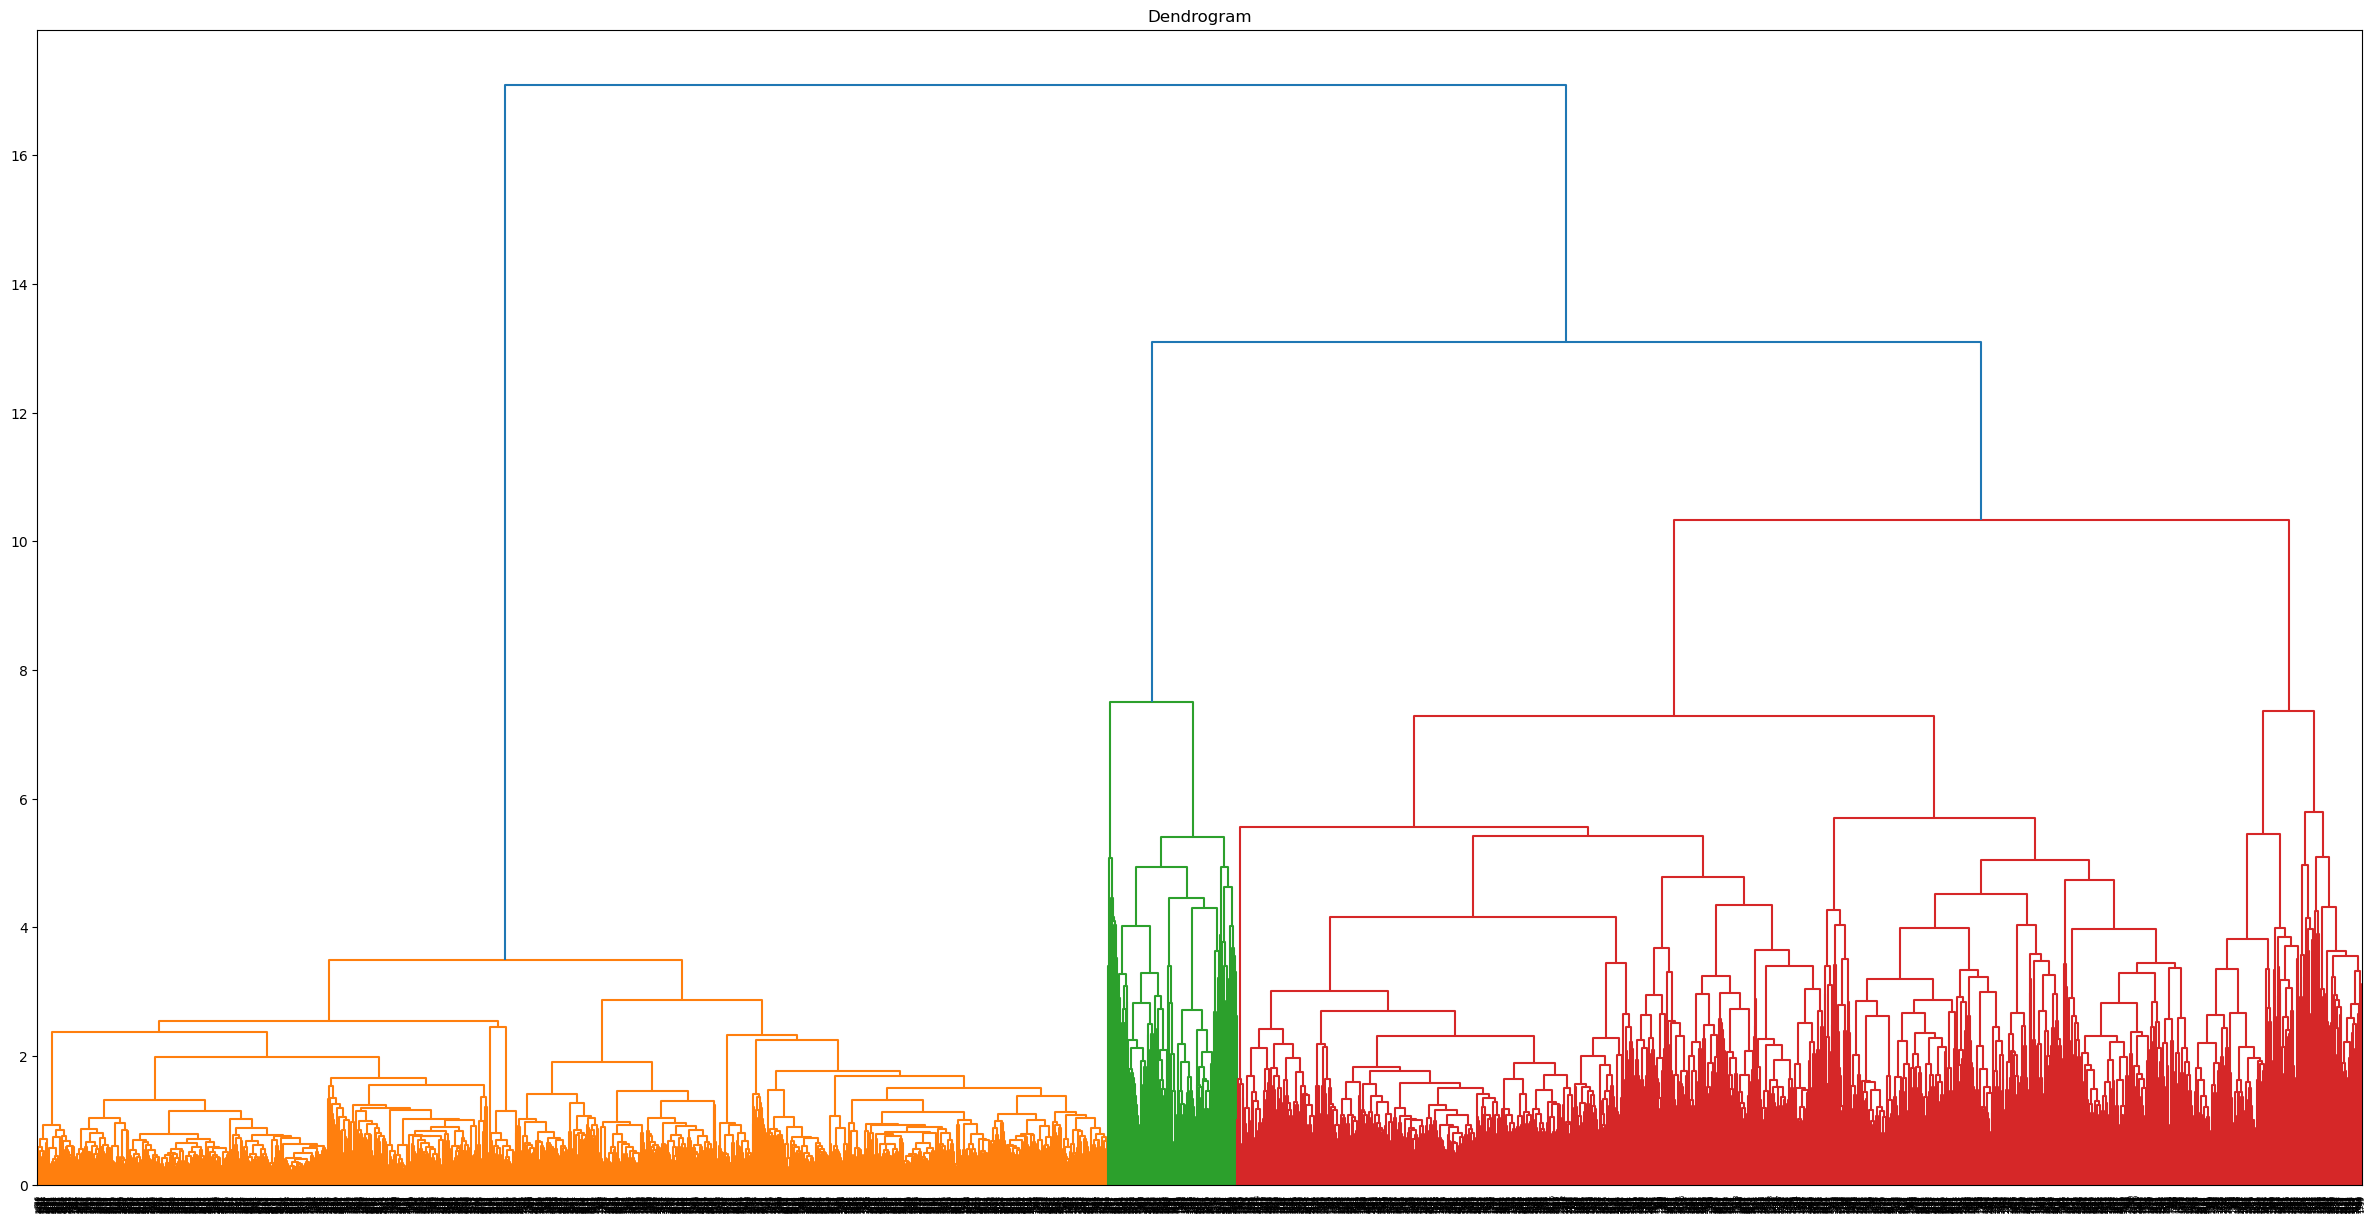

In [100]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Create hierachical clusters
linked = linkage(X,'ward')

# Plot dendrogram
plt.figure(figsize=(30,15))
dendrogram(linked)
plt.title("Dendrogram")
plt.show()

It appears that `distance_threshold=6` would give us **7 well-defined clusters**.

In [102]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

X = aspects_phrases["vectors"].to_list()

# Create list to append avg silhouette scores
silhouette_avg_n_clusters = {}

for K in [7]:
  hc = AgglomerativeClustering(n_clusters=K, linkage='ward')
  hc.fit(X)
  cluster_labels = hc.fit_predict(X)
  aspects_phrases[f"HC K={K} cluster labels"] = cluster_labels
  silhouette_avg = silhouette_score(X, cluster_labels)
  silhouette_avg_n_clusters[K] = silhouette_avg
  print(f"Average silhouette score: {silhouette_avg:.3f}")

Average silhouette score: 0.091


In [104]:
# Let's investigate the words in each cluster
HC_topic_word_dict = {}

for i in range(4):
    words =[]
    HC_topic_word_dict[i] = aspects_phrases["phrases"].loc[aspects_phrases["HC K=7 cluster labels"]==i].to_list()

HC_topic_word_dict

{0: ['kid',
  'sword',
  'map',
  'slot',
  'tip',
  'cup',
  'tag',
  'fix',
  'shoe',
  'cue',
  'stitch',
  'leg',
  'fit',
  'bar',
  'wife',
  'crow',
  'son',
  'bag',
  'hat',
  'lay',
  'fry',
  'dine',
  'eat',
  'plug',
  'carp',
  'face',
  'boy',
  'tap',
  'row',
  'ear',
  'tea',
  'bed',
  'grind',
  'drop',
  'stich',
  'jack',
  'foot',
  'bite',
  'sit',
  'chip',
  'push',
  'shove',
  'cat',
  'mat',
  'pot',
  'fish',
  'man',
  'ring',
  'fill',
  'rid',
  'bell',
  'rug',
  'duck',
  'box',
  'top',
  'rope',
  'rank',
  'loop',
  'rib',
  'dog',
  'dad',
  'flip',
  'rex',
  'guy',
  'spit',
  'eye',
  'pan',
  'honk',
  'cut',
  'nap',
  'curve',
  'poke',
  'coin',
  'god',
  'laid',
  'pin',
  'sir',
  'angle',
  'bin',
  'kick',
  'twist',
  'tape',
  'torn',
  'cap',
  'load',
  'glue',
  'strap',
  'rids',
  'snap',
  'bow',
  'mom',
  'swing',
  'slide',
  'cop',
  'heel',
  'heal',
  'cad',
  'feed',
  'boot',
  'knee',
  'fly',
  'hand',
  'jerk',
  'ra

Still not very meaningful...

## 3.4 Targeted Topic Modelling

### 3.4.1 Load predefined word bank
First, we use the word bank defined by the Topic Modelling team.

In [66]:
# Create word bank for each topic

topic2word = {"atmosphere_theme": ['atmosphere', 'theme', 'awesome', 'magical', 'happy', 'happiest', 'best', 'adventureland', 'fantasyland', 'tomorrowland', 'treasure', 'cove', 'gardens', 'imagination', 'mickey', 'avenue', 'adventure', 'isle', 'toontown', 'critter', 'country', 'vibe', 'ambience', 'environment', 'ambiance', 'joyful', 'surroundings', 'design', 'magic', 'charm'],
            "capacity_queue" : ['queue', 'q', 'que', 'queuing', 'queing', 'cut', 'push', 'line', 'wait', 'waiting', 'capacity', 'crowd', 'app', 'long', 'push', 'busy', 'fastpass', 'pass', 'lineup', 'fp', 'fastpasses', 'crowded', 'crowds', 'busy', 'overcrowd'],
            "staff_service" : ['staff', 'crew', 'friendly', 'helpful', 'rude', 'worker', 'personnel', 'polite', 'courteous', 'cast', 'professional', 'team', 'employee', 'assist', 'attentive', 'unfriendly'],
            "food_merch" : ['food', 'restaurant', 'shop', 'merchandise', 'lunch', 'dinner', 'meal', 'popcorn', 'souvenir', 'drink', 'snack', 'eat', 'affordable', 'expensive', 'cheap', 'beverage', 'tasty', 'dining', 'taste', 'costly', 'pricy', 'eatery', 'pricey', 'merch', 'outlet', 'eatery', 'cafe', 'halal', 'dine', 'diner', 'store', 'shopping', 'gift', 'item', 'retail'],
            "ride_attraction" : ['ride', 'rides', 'attraction', 'fastpass', 'pass', 'rollercoaster', 'rid', 'acitvity', 'game', 'roller coaster'],
            "entertainment_show" : ['show', 'entertainment', 'parade', 'character', 'mickey', 'minni', 'goofy', 'donald', 'pluto', 'daffy', 'firework', 'activity', 'activities', 'attraction', 'castle', 'performance', 'musical', 'theatre', 'theater', 'display', 'finale', 'production', 'princess'],
            "accessibility_convenience" : ['metro', 'train', 'app', 'apps', 'taxi', 'subway', 'bay', 'mrt', 'railway', 'rail', 'transfer', 'brochure'],
            "facilities_environment" : ['facility', 'environment', 'toilet', 'dirty', 'clean', 'security', 'vegetation', 'scenery', 'surroundings', 'layout', 'spotless', 'amenity', 'restroom', 'cleanliness', 'landscaping', 'bathroom', 'washroom', 'trash', 'litter', 'cubicle', 'smoking', 'bin'],
            "pricing_value" : ['price', 'cost', 'ticket', 'expensive', 'cheap', 'value', 'worth', 'fee', 'pricey', 'affordable', 'fare', 'admission', 'pricing', 'costly', 'tix', 'voucher', 'promo', 'entry', 'entrance', 'discount', 'discounted']
            }


In [67]:
# Remap into {word:topic}
word2topic = {}

for topic, word_list in topic2word.items():
    for word in word_list:
        word2topic[word] = topic

### 3.4.2 Map the aspect to the closest topic
We calculate the **cosine similarity** for each aspect with every word in the `word2topic` dictionary, and return the topic that has the closest matched word

In [68]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to get the closest topic based on cosine similarity
def get_best_topic(aspect, word2topic):
    closest_word = 0
    max_sim = -1 # cosine similarity is bounded between (0,1)
    v1 = model[aspect].reshape(1, -1)

    for word in word2topic.keys():
        v2 = model[word].reshape(1, -1)
        sim = cosine_similarity(v1,v2)
        if sim > max_sim:
            max_sim = sim
            best_topic = word2topic[word]
    return best_topic


In [69]:
# Mapping topic to aspects in this format {aspect:topic}

print("Mapping topics to unique aspects. This will take around 5 mins.")
aspect2topic = {aspect:get_best_topic(aspect, word2topic) for aspect in aspects_phrases["phrases"].to_list()}

print("Mapping topics in the actual dataframe...")
df.loc[:,"Predicted_topic"]=df['ABSA_aspect_clean'].apply(lambda x: aspect2topic[x])
print("Done!")

Mapping topics to unique aspects. This will take around 5 mins.
Mapping topics in the actual dataframe...
Done!


In [70]:
# Export to csv
df.to_csv(PATH+"/data/ABSA_topic_sentiment.csv", index = False)

# 4. Model Evaluation

In [131]:
# Import evaluation data (earlier we have selected 31 random reviews)
df_eval = pd.read_excel(PATH+'/data/df_eval.xlsx', sheet_name='df_eval_ABSA')
df_eval = df_eval.fillna('0')

# # Prepare lists
y_pred_senti = df_eval['ABSA_sentiment'].to_list()
y_pred_aspect = df_eval['ABSA_aspect_clean'].to_list()
y_pred_topic = df_eval['Predicted_topic'].to_list()

y_senti = df_eval['Actual_sentiment'].to_list()
y_aspect = df_eval['Actual_aspect'].to_list()
y_topic = df_eval['Actual_topic'].to_list()

print(f"{len(df_eval['Review_ID'].unique())} reviews in evaluation.")

40 reviews in evaluation.


In [132]:
# Show classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

# Define function to evaluate
def evaluate(y_true, y_pred, labels):

  # Classification report
  print(classification_report(y_true, y_pred))

  # Confusion matrix
  cm = confusion_matrix(y_true, y_pred, labels=labels)

  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #ftm='g' to disable scientific notation

  # labels, title and ticks
  ax.set_title('Confusion Matrix')
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.xaxis.set_ticklabels(labels, rotation=90)
  ax.yaxis.set_ticklabels(labels, rotation=0)
  plt.show()

## 4.1 Evaluating aspects
We look at the **F1 score**, since we have many classes and sparse data. Expectedly, performance was not great mainly becuase
1. Review data was not clean. For example, some reviews had "fire works" vs "fireworks".
2. There were too many aspects, partially compounded due to point 1.
3. Not enough labelled data.

In [133]:
print(classification_report(y_aspect, y_pred_aspect))

                     precision    recall  f1-score   support

                  0       0.00      0.00      0.00        24
           activity       0.00      0.00      0.00         0
          amenities       0.00      0.00      0.00         1
               area       1.00      1.00      1.00         1
         attraction       0.75      0.43      0.55         7
    attraction ride       0.00      0.00      0.00         0
         background       0.00      0.00      0.00         0
           car ride       1.00      1.00      1.00         1
          caractets       0.00      0.00      0.00         0
  cartoon character       0.00      0.00      0.00         0
             castle       0.00      0.00      0.00         1
          character       0.75      0.50      0.60         6
              clean       0.00      0.00      0.00         1
               coca       0.00      0.00      0.00         0
          coca cola       0.00      0.00      0.00         0
       construction    

/Users/sx/miniconda3/envs/isss609/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sx/miniconda3/envs/isss609/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sx/miniconda3/envs/isss609/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users

## 4.2 Evaluating sentiment

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
    Negative       0.80      0.92      0.86        39
     Neutral       0.52      0.60      0.56        25
    Positive       0.72      0.83      0.77        69

    accuracy                           0.69       157
   macro avg       0.51      0.59      0.55       157
weighted avg       0.60      0.69      0.64       157



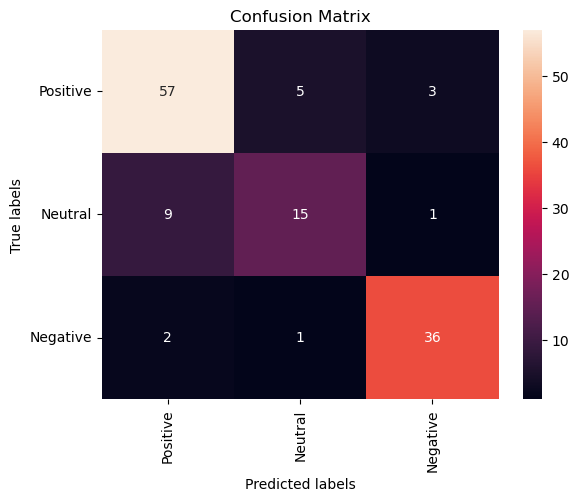

In [134]:
# List the sentiment classes in the order we want them to appear
senti_labels = ["Positive", "Neutral", "Negative"]

evaluate(y_senti, y_pred_senti, senti_labels)

## 4.3 Evaluating topics

                           precision    recall  f1-score   support

                        0       0.00      0.00      0.00        24
accessibility_convenience       0.40      0.40      0.40         5
         atmosphere_theme       0.14      0.14      0.14         7
           capacity_queue       0.66      0.84      0.74        25
       entertainment_show       0.56      0.58      0.57        26
   facilities_environment       0.50      0.50      0.50         4
               food_merch       0.45      0.71      0.56        14
            pricing_value       0.62      0.50      0.55        16
          ride_attraction       0.57      0.68      0.62        31
            staff_service       0.50      0.60      0.55         5

                 accuracy                           0.53       157
                macro avg       0.44      0.50      0.46       157
             weighted avg       0.46      0.53      0.49       157



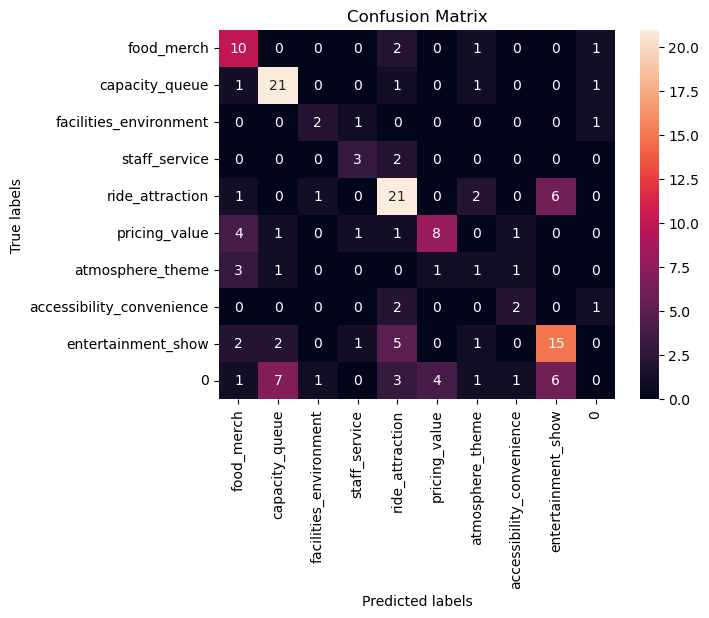

In [135]:
# List the unique topics
topic_labels = df_eval['Predicted_topic'].unique()

evaluate(y_topic, y_pred_topic, topic_labels)

# 4 Analysis

## 4.1 Visualizing aspects mentioned in a topic

In [136]:
# Read the .csv
df = pd.read_csv(PATH+"/data/ABSA_topic_sentiment.csv")

# Get unique topics
unique_topics = set(df["Predicted_topic"].to_list())

# List unique sentiment (we use this order)
unique_sentiment = ["Positive", "Neutral", "Negative"]

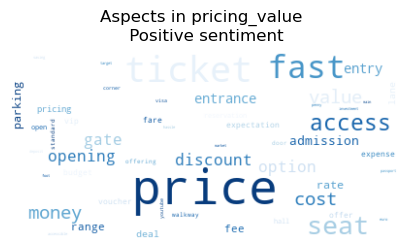

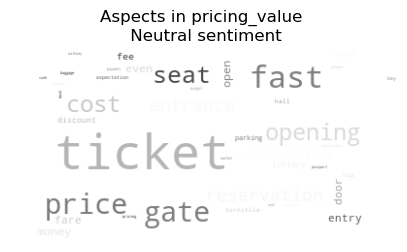

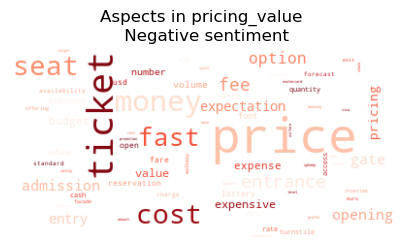

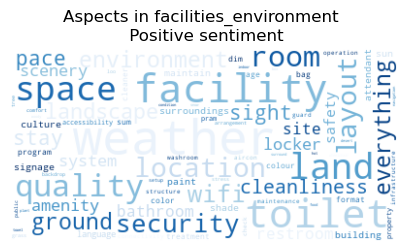

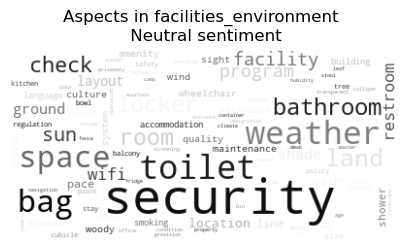

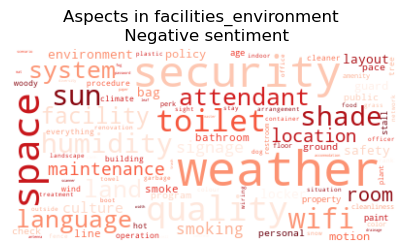

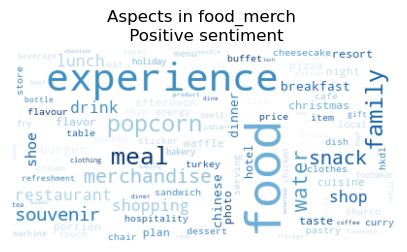

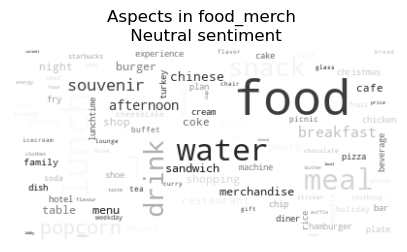

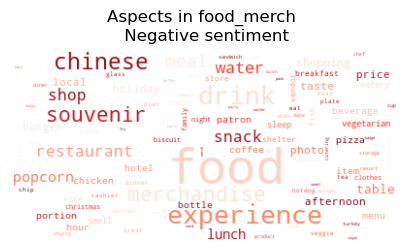

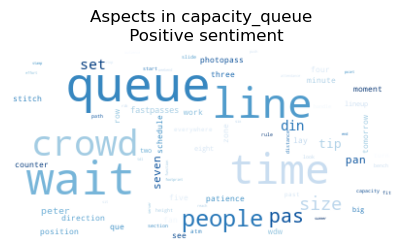

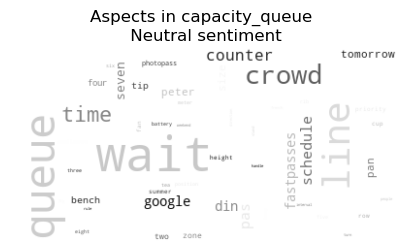

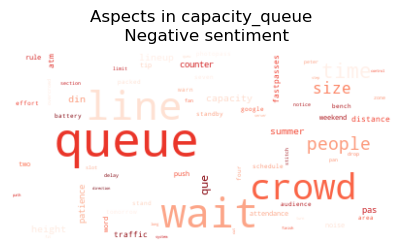

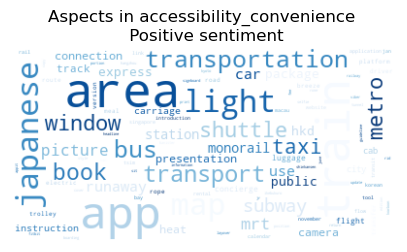

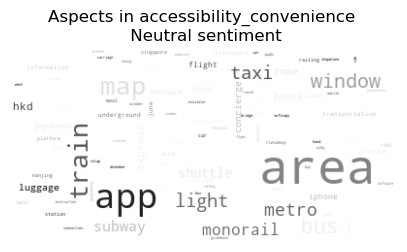

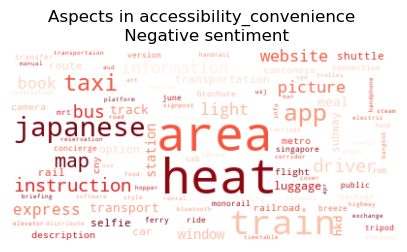

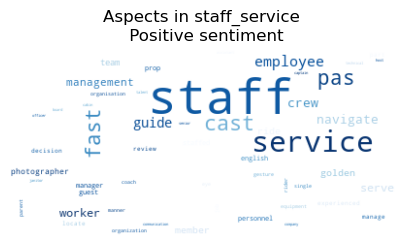

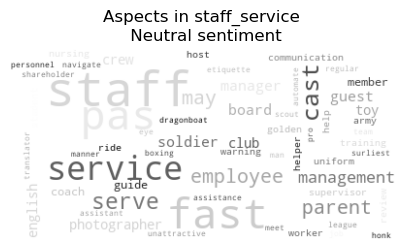

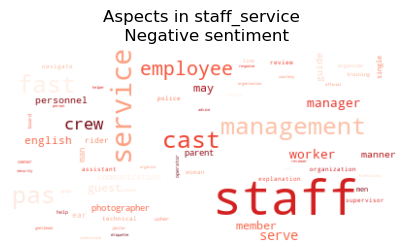

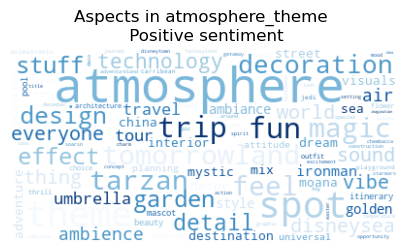

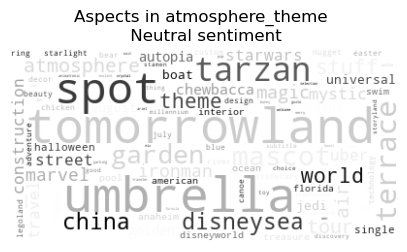

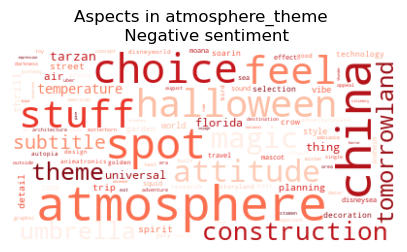

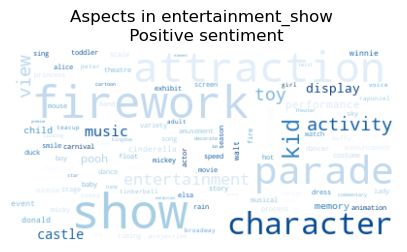

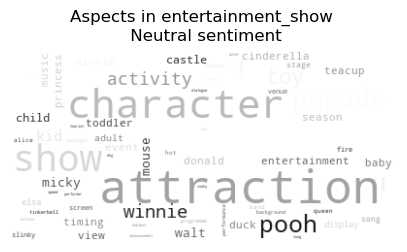

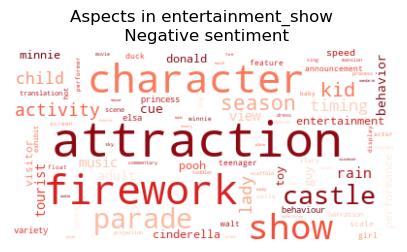

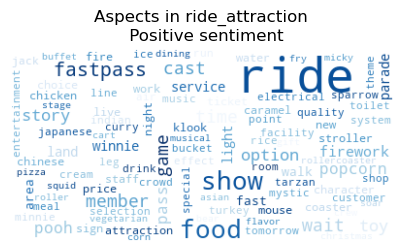

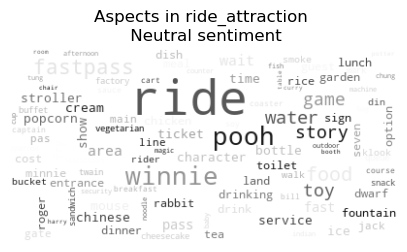

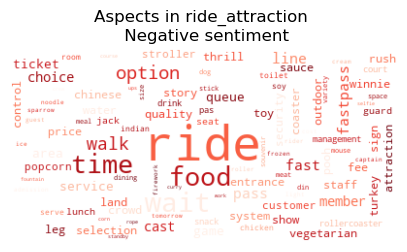

In [139]:
# Plot word clouds
colormapping = {"Positive":"Blues", "Neutral":"Greys", "Negative":"Reds"}

for topic in unique_topics:
    for sentiment in unique_sentiment:
        condition =  (df['Predicted_topic'] == topic) & (df['ABSA_sentiment'] == sentiment)
        wordlist = df.loc[condition, 'ABSA_aspect_clean'].to_list()
        wordlist = " ".join(wordlist)
        
        # Generate the word cloud
        plt.figure(figsize=(5,5))
        plt.title(f"Aspects in {topic} \n {sentiment} sentiment")
        wc = WordCloud(collocations = False, max_font_size=50, max_words=100, background_color="white", colormap=colormapping[sentiment],).generate(wordlist)
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()


## 4.2 Sentiment and topics by branch

In [138]:
# Create a compact df for plotting
df_plot = df.groupby(by=["Branch", "ABSA_sentiment", "Predicted_topic"], as_index=False)["Sentence_ID"].count()

# Rename column "Sentence_ID" to count
df_plot.rename(columns = {"Sentence_ID": "Count"}, inplace = True)

fig = px.bar(df_plot, x='Predicted_topic', y='Count', color = 'ABSA_sentiment',
             facet_row='Branch',
             category_orders={'ABSA_sentiment': ['Positive', 'Neutral', 'Negative']},
             color_discrete_map={'Positive':'#636efa', 'Neutral':'#bab0ac', 'Negative':'#ef553b'},
             height=800,
             title='How do visitors feel about each topic across different branches?'
             )
fig.show()

### 4.3 Positivity scores by topics by branch

In [137]:
# Create a compact df for plotting
# Create a positivity score for each topic. E.g. if "staff_service" has 100 sentences and 40 are positive, then positivity = 0.4
df_plot1 = df.groupby(by=["Branch", "Predicted_topic"], as_index=False)["Sentence_ID"].count()
df_plot1.rename(columns = {"Sentence_ID": "Total_count"}, inplace = True)

df_plot2 = df.groupby(by=["Branch", "Predicted_topic", "ABSA_sentiment"], as_index=False)["Sentence_ID"].count()
df_plot2.rename(columns = {"Sentence_ID": "Count"}, inplace = True)


merged = pd.merge(df_plot2, df_plot1, how='left', on=['Branch','Predicted_topic'])
merged['positivity'] = merged['Count']/merged['Total_count']
merged_pos = merged[merged['ABSA_sentiment']=="Positive"]

topics = merged_pos["Predicted_topic"].unique().tolist()
branches = merged_pos["Branch"].unique().tolist()
branches

for branch in branches:
    d = merged_pos[merged_pos['Branch']==branch]
    df_plot = pd.DataFrame(dict(r=d["positivity"],
                                theta=topics))
    fig = px.line_polar(df_plot, r='r', theta='theta', title=f'% positive mentions for topics in {branch}')
    fig.update_traces(fill='toself')
    fig.update_layout(polar=dict(radialaxis=dict(range=[0, 1])))
    fig.show()
